### Imports

In [ ]:
import os
import tensorflow.keras.backend as K
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.layers import MaxPooling2D
import tensorflow as tf
from tensorflow.keras.layers import Lambda
from tensorflow.keras.datasets import mnist

### Constants

In [ ]:
IMG_SHAPE = (28, 28, 1)
BATCH_SIZE = 64
EPOCHS = 10

### Create Pairs

In [ ]:
def make_pairs(images, labels):
    # initialize two empty lists to hold the (image, image) pairs and
    # labels to indicate if a pair is positive or negative
    pair_images = []
    pair_labels = []
    # calculate the total number of classes present in the dataset
    # and then build a list of indexes for each class label that
    # provides the indexes for all examples with a given label
    num_classes = len(np.unique(labels))
    images_per_label_list = [np.where(labels == i)[0] for i in range(0, num_classes)]
    # loop over all images
    for img_ind_first in range(len(images)):
        # grab the current image and label belonging to the current
        # iteration
        current_img = images[img_ind_first]
        label = labels[img_ind_first]
        # randomly pick an image that belongs to the *same* class
        # label
        img_ind_second = np.random.choice(images_per_label_list[label])
        pos_img = images[img_ind_second]
        # prepare a positive pair and update the images and labels
        # lists, respectively
        pair_images.append([current_img, pos_img])
        pair_labels.append([1])
        # grab the indices for each of the class labels *not* equal to
        # the current label and randomly pick an image corresponding
        # to a label *not* equal to the current label
        possible_ned_inds = np.where(labels != label)[0]
        neg_img = images[np.random.choice(possible_ned_inds)]
        # prepare a negative pair of images and update our lists
        pair_images.append([current_img, neg_img])
        pair_labels.append([0])
    # return a 2-tuple of our image pairs and labels
    return (np.array(pair_images), np.array(pair_labels))

### Euclidean Distnace

In [ ]:
def euclidean_distance(vectors):
    # unpack the vectors into separate lists
    (embed_1, embed_2) = vectors
    # compute the sum of squared distances between the vectors
    sum_squared = K.sum(K.square(embed_1 - embed_2), axis=1,
                       keepdims=True)
    # return the euclidean distance between the vectors
    return K.sqrt(K.maximum(sum_squared, K.epsilon()))


### Create network for Embedding

In [ ]:
def get_embeding_vector(input_shape, embedding_dim=48):
    # specify the inputs for the feature extractor network
    inputs = Input(input_shape)
    # define the first set of CONV => RELU => POOL => DROPOUT layers
    x = Conv2D(64, (2, 2), padding="same", activation="relu")(inputs)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.3)(x)
    # second set of CONV => RELU => POOL => DROPOUT layers
    x = Conv2D(64, (2, 2), padding="same", activation="relu")(x)
    x = MaxPooling2D(pool_size=2)(x)
    x = Dropout(0.3)(x)
    # prepare the final outputs
    pooledOutput = GlobalAveragePooling2D()(x)
    outputs = Dense(embedding_dim)(pooledOutput)
    # build the model
    model = Model(inputs, outputs)
    # return the model to the calling function
    return model

### Contrastive Loss

In [ ]:
def contrastive_loss(y, preds, margin=1):
    # explicitly cast the true class label data type to the predicted
    # class label data type (otherwise we run the risk of having two
    # separate data types, causing TensorFlow to error out)
    y = tf.cast(y, preds.dtype)
    # calculate the contrastive loss between the true labels and
    # the predicted labels
    squared_preds = K.square(preds)
    squared_margin = K.square(K.maximum(margin - preds, 0))
    loss = K.mean(y * squared_preds + (1 - y) * squared_margin)
    # return the computed contrastive loss to the calling function
    return loss

### Plotting Loss Function

In [ ]:
def plot_training(H):
    # construct a plot that plots and saves the training history
    plt.style.use("ggplot")
    plt.figure()
    plt.plot(H.history["loss"], label="train_loss")
    plt.plot(H.history["val_loss"], label="val_loss")
    plt.title("Training Loss")
    plt.xlabel("Epoch #")
    plt.ylabel("Loss")
    plt.legend(loc="lower left")


### Create Dataset

In [ ]:
# load dataset and scale the pixel values to the range of [0, 1]
(train_x, train_y), (test_x, test_y) = mnist.load_data()
train_x = train_x / 255
test_x = test_x / 255
# add a channel dimension to the images
train_x = np.expand_dims(train_x, axis=-1)
test_x = np.expand_dims(test_x, axis=-1)

# prepare the positive and negative pairs
(pair_train, label_train) = make_pairs(train_x, train_y)
(pair_test, label_test) = make_pairs(test_x, test_y)

### Create Siamese Network

In [ ]:
img_1 = Input(shape=IMG_SHAPE)
img_2 = Input(shape=IMG_SHAPE)
embeding_extractor = get_embeding_vector(IMG_SHAPE)
embed_1 = embeding_extractor(img_1)
embed_2 = embeding_extractor(img_2)

# construct the siamese network
distance = Lambda(euclidean_distance)([embed_1, embed_2])
model = Model(inputs=[img_1, img_2], outputs=distance)

### Train model

In [ ]:
# compile the model
model.compile(loss=contrastive_loss, optimizer="adam")
# train the model
print("[INFO] training model...")
history = model.fit(
    [pair_train[:, 0], pair_train[:, 1]], label_train[:],
    validation_data=([pair_test[:, 0], pair_test[:, 1]], label_test[:]),
    batch_size=BATCH_SIZE,
    epochs=EPOCHS)

[INFO] training model...
Epoch 1/10
1875/1875 [==============================] - 10s 4ms/step - loss: 0.2198 - val_loss: 0.1693
Epoch 2/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.1801 - val_loss: 0.1498
Epoch 3/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.1621 - val_loss: 0.1373
Epoch 4/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.1539 - val_loss: 0.1319
Epoch 5/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.1496 - val_loss: 0.1279
Epoch 6/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.1456 - val_loss: 0.1231
Epoch 7/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.1425 - val_loss: 0.1190
Epoch 8/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.1417 - val_loss: 0.1178
Epoch 9/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.1402 - val_loss: 0.1193
Epoch 10/10
1875/1875 [==============================] -

### Plot Loss

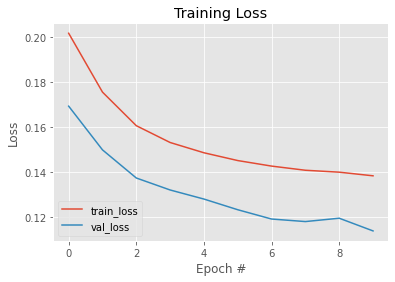

In [ ]:
plot_training(history)

### Test the model

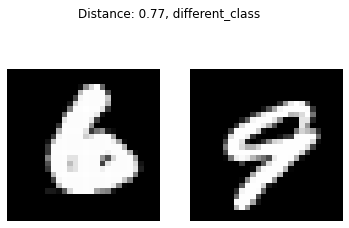

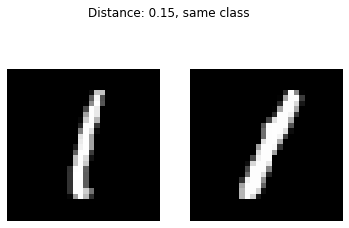

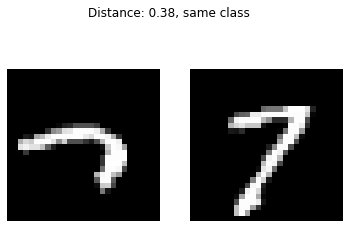

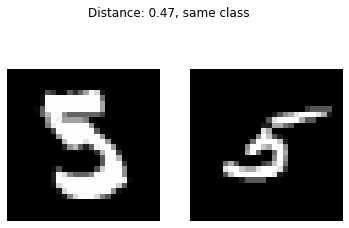

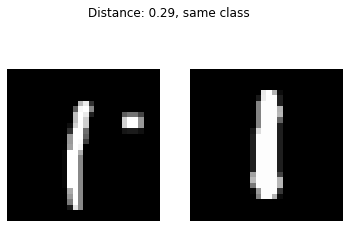

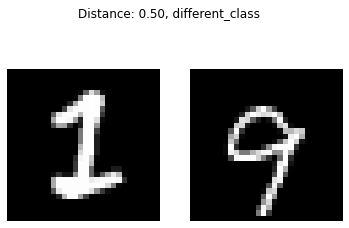

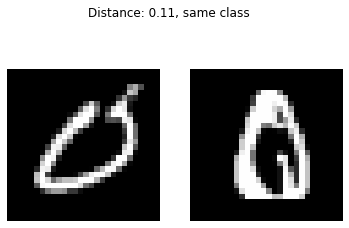

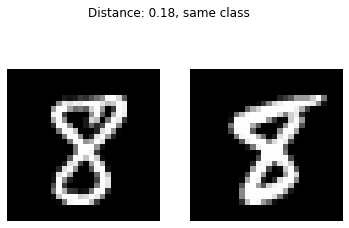

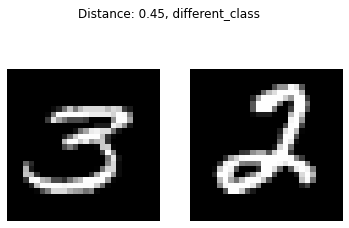

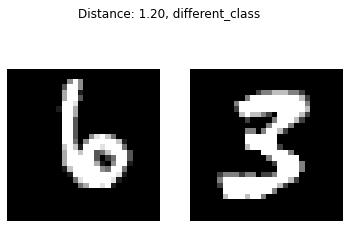

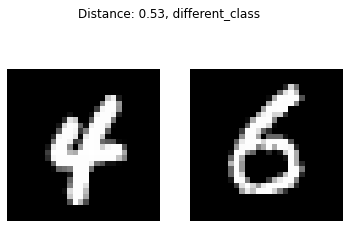

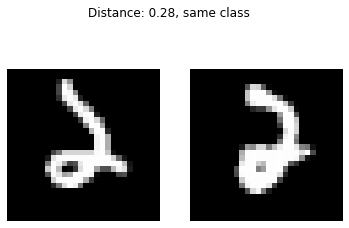

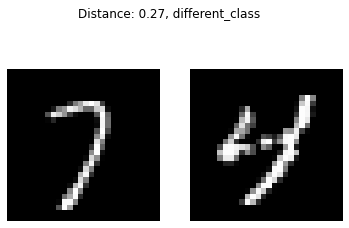

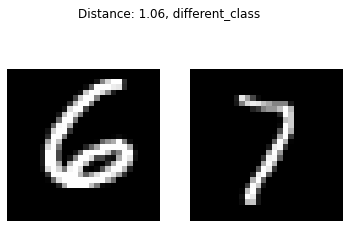

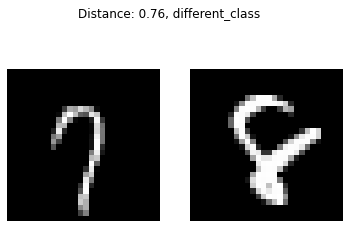

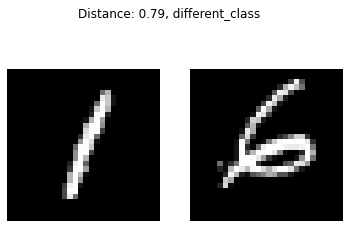

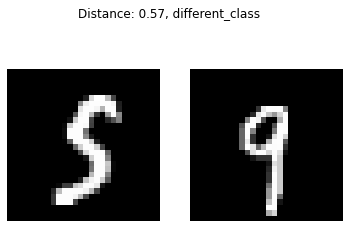

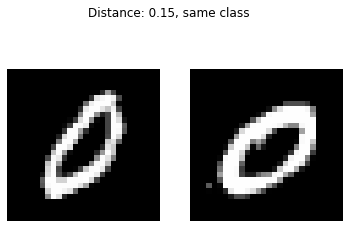

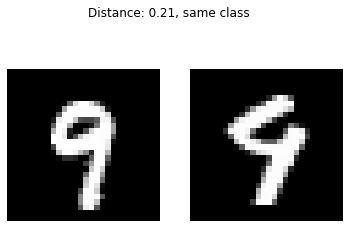

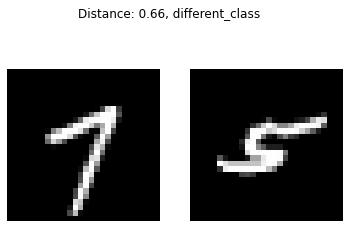

In [ ]:
np.random.seed(42)
num_test_samples = pair_test.shape[0]
num_test_samples_check = 20
random_test_inds = np.random.choice(num_test_samples, num_test_samples_check)

for rand_ind in random_test_inds:

    # rand_ind = random_test_inds[0]
    img_1 = np.expand_dims(pair_test[rand_ind][0], axis=0)
    img_2 = np.expand_dims(pair_test[rand_ind][1], axis=0)
    is_same_class = label_test[rand_ind]
    preds = model.predict([img_1, img_2])
    proba = preds[0][0]
    
    fig = plt.figure(figsize=(6, 4))
    label_text = "same class" if is_same_class else "different_class"
    plt.suptitle("Distance: {:.2f}, {}".format(proba, label_text))
    # show first image
    ax = fig.add_subplot(1, 2, 1)
    orig_img_1 = img_1.reshape((28,28))
    orig_img_2 = img_2.reshape((28,28))
    plt.imshow(orig_img_1, cmap=plt.cm.gray)
    plt.axis("off")
    # show the second image
    ax = fig.add_subplot(1, 2, 2)
    plt.imshow(orig_img_2, cmap=plt.cm.gray)
    plt.axis("off")
    # show the plot
    plt.show()
